# Intro

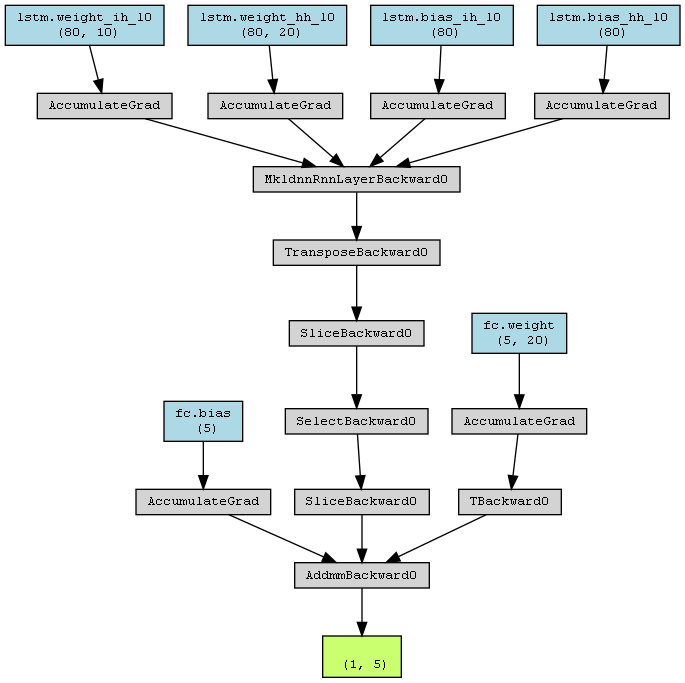

__Attention in deep learning__

NN + attention -> Modern AI

# Seq2Seq model

__Sequence to Sequence model__

시퀀스를 입력받아 시퀀스를 반환하는 모델

예:
- 영어 문장(시퀀스)를 받아 불어 문장(시퀀스)로 변환하는 번역 모델, '기계번역'
- 영어 문장을 변환하는 부분이 인코더, 불어 문장으로 출력하기 위해 변환하는 부분이 디코더

RNN:
- input: $(x_1, ..., x_T)$
- Output: $(y_1, ..., y_T)$

$$
h_t = \sigma (W^{hx} x_t + W^{hh}h_{t-1})
$$

$$
y_t = W^{yh}h^t
$$

일반적인 시퀀스 라벨링과는 달리, 입력과 출력의 시퀀스 길이가 다른 문제를 풀고자 한다. 이것을 위해선 시퀀스 처리 과정이 입력 시퀀스 처리와 출력 시퀀스 처리로 이원화되어야 한다. 결국 하나의 RNN으로는 문제를 해결할 수 없다.

$$
p(y_1, ..., y_{T'}| x_1, ..., x_T)
$$

위 확률을 계산하는 방법:

1. 고정된 차원의 벡터 $v$가 $x_1, ..., x_T$를 입력으로 받는 LSTM으로부터 얻어진다.
    - 이는 시간 $T$에서의 은닉층의 은닉상태이다.

2. 초기 상태가 $v$로 설정된 표준적인 LSTM-LM이 사용된다.

그 언어 모델은 아래의 확률을 계산할 수 있다.

$$
p(y_t|v,y_1,...,y_{t-1})
$$

이는 다음을 입력으로 받는 LSTM 모델에 의해 구현된다.
- 시간 1에서의 $v$를 이전 상태 벡터로 사용한다.
- 시간 $t$에서, 그 모델은 입력층에서 $y_{t-1}$의 단어 벡터를 받는다. 
    - 그 단어는 시간 $t-1$에서의 디코더가 생성한 것이다. 
- 시간 1에서의 입력 단어는 $\text{<EOS>}$로 고정한다.
- 주의: 시간 $t$에서 생성된 단어는 $t-1$ 시점까지 생성된 단어 시퀀스 $(y_1, ...,y_{t-1})$에 의한 것이다.
- 이것이 언어 모델이 하는 일이다.

그래서 모델은 문장 전체의 확률을 계산할 수 있다.

$$
p(y_1, ..., y_{T'}|x_1, ..., x_T) = \prod_{t=1}^{T'}p(y_t|v,y_1,...,y_{t-1})
$$

$p(y_t|v,y_1,...,y_{t-1})$의 분포는 사전에 있는 모든 단어에 대한 소프트맥스 레이어에 의해 계산된다.

단어 $\text{<EOS>}$가 생성되면 문장을 끝낸다.
- 이를 통해 문장을 생성하고, 그 확률(문장에 대한 확률 분포)을 계산할 수 있다.

---

인코더를 위한 LSTM은 디코더를 위한 것과는 다르다.  
심층 LSTM들이 더 잘 작동한다.    
입력 문장은 인코더에 역순으로 주어진다.  
디코더는 목표 문장의 순방향으로 생성하도록 만들어진다.

# Attention mechanism

Attention의 정의:
- Query와 Key-Value 쌍의 집합 → Output 생성
- Output = 각 Value에 가중치를 부여한 Value들의 가중합이며, 이 가중치는 Query와 해당 Key 간의 **compatibility(적합성) 또는 coherence(밀접도)** 에서 계산된다.
    - (그림 참고)
    - Query가 Value 시퀀스를 attention하여 중첩된 value를 구함.

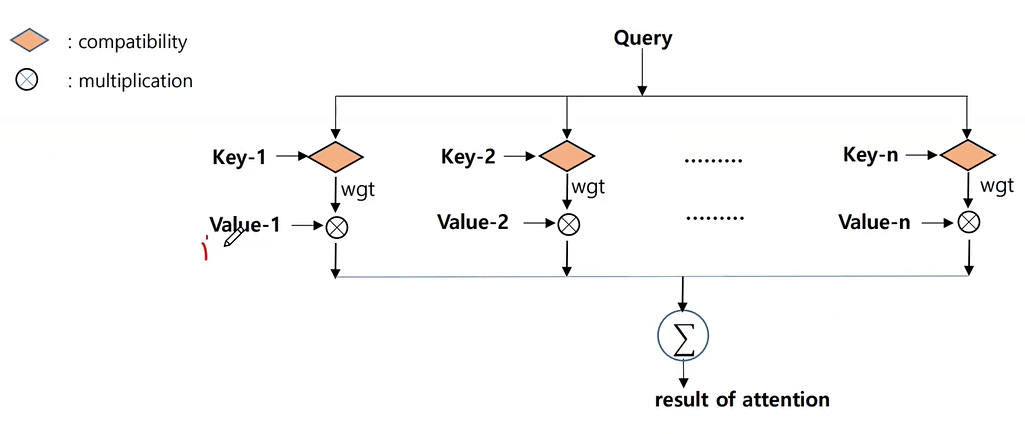

## LSTM 인코더-디코더 복습

입력 시퀀스 벡터: $\mathbf{x}=(x_1, ...,x_{T_x})$  
은닉 상태: $h_t = f(x_t, h_{t-1})$  
고정 길이 벡터: $c=q(\{h_1,\cdots, h_{T_x} \})$

$f$와 $q$: 비선형 함수

RNN 디코더 모델:
$$
p(y_t|\{y_1,\cdots,y_{t-1} \},c)=g(y_{t-1}, s_t, c)
$$

$$
p(\mathbf{y}) = \prod^T_{t=1}p(y_t|\{y_1,\cdots,y_{t-1} \},c)
$$

여기서:
- $g$는 비선형의, 잠재적으로 다층의 함수
- $s_t$는 RNN의 은닉 상태

## Alignment

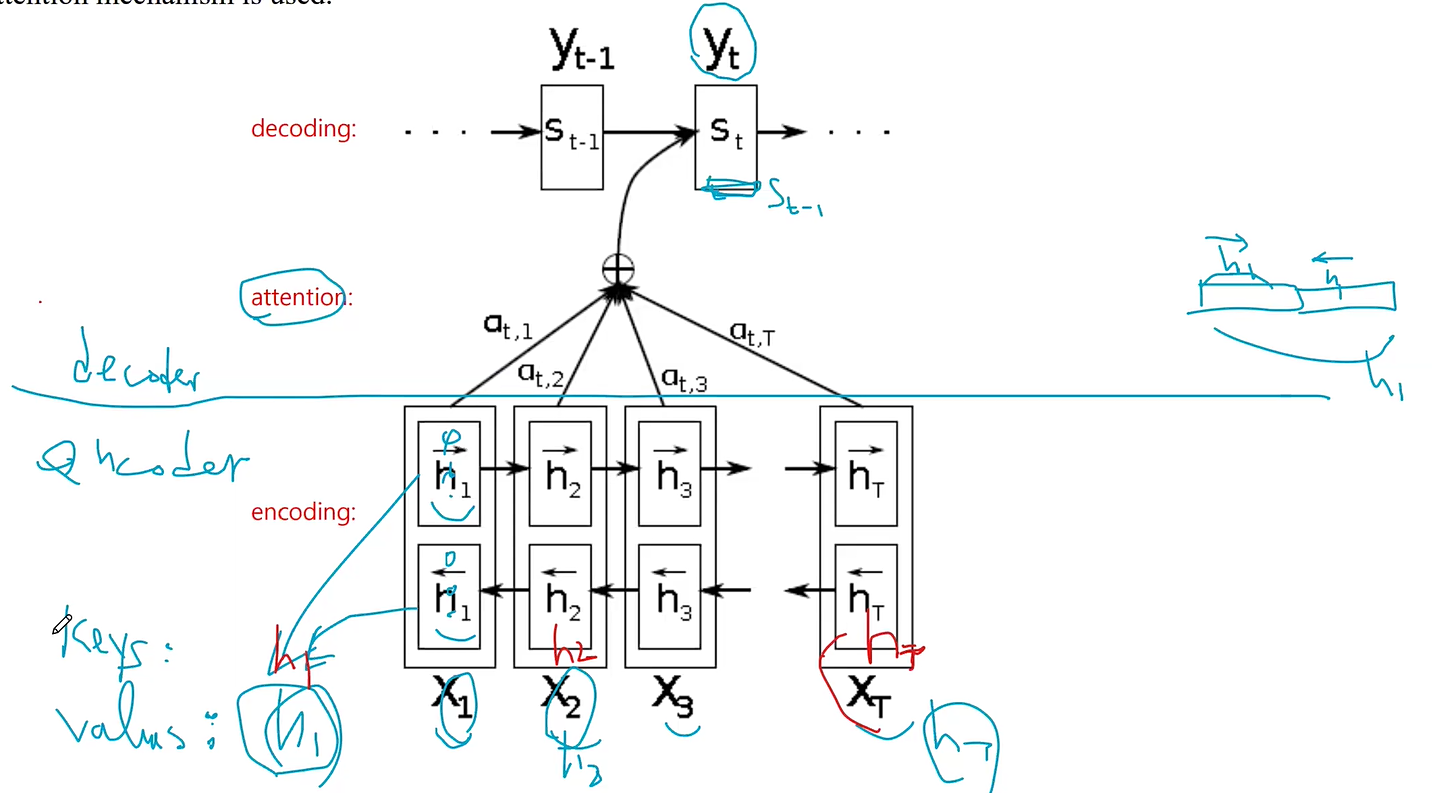

디코더상에서 이전 시간의 은닉 상태를 쿼리 벡터로, 인코더의 모든 은닉 상태를 키와 값 벡터로 하여 어텐션을 적용한다. 

이 때, 인코더의 은닉 상태와 디코더의 이전 시간 은닉 상태의 차원을 맞추고 성능을 높이기 위해 인코더의 은닉 상태를 가중합하여 키와 값 벡터로 변환하여 사용한다.

---

### **1. 디코더의 이전 시간 은닉 상태를 Query로 사용**
- 디코더의 **이전 시간의 은닉 상태**는 Query 벡터로 사용됩니다.  
  - 디코더는 이전의 출력과 은닉 상태를 기반으로 다음 단어를 예측하므로, 이전 시간의 은닉 상태를 Query로 삼는 것은 적절합니다.
  - Query는 Attention 메커니즘에서 현재 디코더 상태가 **어느 인코더 상태에 집중할지**를 결정하는 데 사용됩니다.

---

### **2. 인코더의 모든 은닉 상태를 Key와 Value로 사용**
- 인코더의 은닉 상태는 디코더가 입력 문장의 중요한 부분에 집중할 수 있도록 **Key와 Value**로 사용됩니다.
  - **Key**는 Query와의 상관성을 계산하는 데 사용됩니다.  
  - **Value**는 Attention 가중치(합계가 1인 확률 분포)로 가중합을 계산하여 최종 Context 벡터를 생성하는 데 사용됩니다.

---

### **3. 차원 맞춤 및 성능 향상**
- **인코더 은닉 상태와 디코더 은닉 상태의 차원 맞춤**은 매우 중요합니다. 이유는:
  1. Query(Key)와 Key(Query)의 내적 또는 점곱(dot product)을 통해 Attention 점수를 계산하기 때문에, 벡터의 차원이 일치해야 합니다.
  2. 인코더의 은닉 상태가 디코더에 바로 전달되지 않고, 차원을 변환하여 **더 풍부한 표현**을 제공하거나 계산 효율성을 높이기 위해 가중합(weighted transformation)을 적용합니다.
     - 이 변환은 일반적으로 **선형 변환(Linear Projection)** 을 통해 이루어집니다:
       $$
       K = W_k \cdot H_{\text{encoder}}, \quad V = W_v \cdot H_{\text{encoder}}
       $$
       여기서 $(W_k)$와 $(W_v)$는 학습 가능한 가중치 행렬입니다.
  3. 이 과정에서 Attention 모델의 학습 가능성이 높아지고, **성능 향상**에 기여합니다.

---

### **정리된 설명**
1. 디코더의 이전 시간 은닉 상태를 Query 벡터로 사용한다.  
2. 인코더의 모든 은닉 상태를 Key와 Value로 사용한다.  
3. Key와 Query 간의 차원을 맞추기 위해 인코더의 은닉 상태를 학습 가능한 가중치 행렬로 변환한 후 Key와 Value로 생성한다.  
4. 이 변환은 차원을 일치시키는 동시에 성능을 높이기 위한 방법으로 사용된다.

---

## 디코더

$g$ 함수(LSTM 모델)는 조건부 확률을 모델링한다.

$$
p(y_i|y_1,...,y_{i-1},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

RNN의 은닉 상태는:

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

여기서 확률은 각 타겟 단어 $ y_i $에 대해 고유한 **컨텍스트 벡터 $ c_i $** 에 조건부로 정의된다.

인코더는 주석(annotations)의 시퀀스를 생성한다: $(h_1, \cdots, h_{T_x})$

정렬(alignment) 모델:
- 컨텍스트 벡터는 디코딩을 할 동안 생성된 각각의 $i$번째 단어에 대해 준비된다.
$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

- 여기서 가중치 $\alpha_{ij}$가 사용된다.

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x}\exp(e_{ik})},\quad \text{where } e_{ij} = a(s_{i-1}, h_j)
$$

여기서:
- $s_{i-1}$은 디코더상의 시간 $i-1$에서의 은닉 상태, 쿼리 역할
- $h_j$는 인코더상의 시간 $j$에서의 은닉 상태, 밸류와 키 역할

이 가중치는 위치 $j$ 주변의 입력이 위치 $i$의 출력과 얼마나 잘 맞아떨어지는지 평가한다.

---

- 정렬 모델의 파라미터는 번역 모델과 함께 역전파를 통해 공동으로 학습됩니다.
- $\alpha_{ij}$: 타겟 단어 $y_i$가 소스 단어 $x_j$에 정렬되고, 따라서 $x_j$로부터 번역될 확률을 나타냅니다.
- $C_i$: $\alpha_{ij}$의 확률 분포를 기반으로 모든 어노테이션 $h_j$에 대해 기대값을 계산한 컨텍스트 벡터입니다 $(j = 0, ..., T_x - 1)$.
- $\alpha_{ij}$는 이전 은닉 상태 $s_{i-1}$와의 관계를 바탕으로 $h_j$의 중요도를 반영하며, $s_i$를 결정하고 $y_i$를 생성하는 데 사용됩니다.
- 이는 디코더에서 어텐션 메커니즘을 구현한 것입니다.
- 디코더는 소스 문장의 특정 부분에 집중할지를 결정합니다.
- 디코더에 어텐션 메커니즘을 도입함으로써, 소스 문장의 모든 정보를 고정된 길이 벡터에 인코딩해야 하는 인코더의 부담을 덜어줍니다.
- 이 새로운 접근법을 통해 정보는 어노테이션의 시퀀스 전체에 분산될 수 있으며, 디코더는 필요에 따라 이를 선택적으로 검색할 수 있습니다.

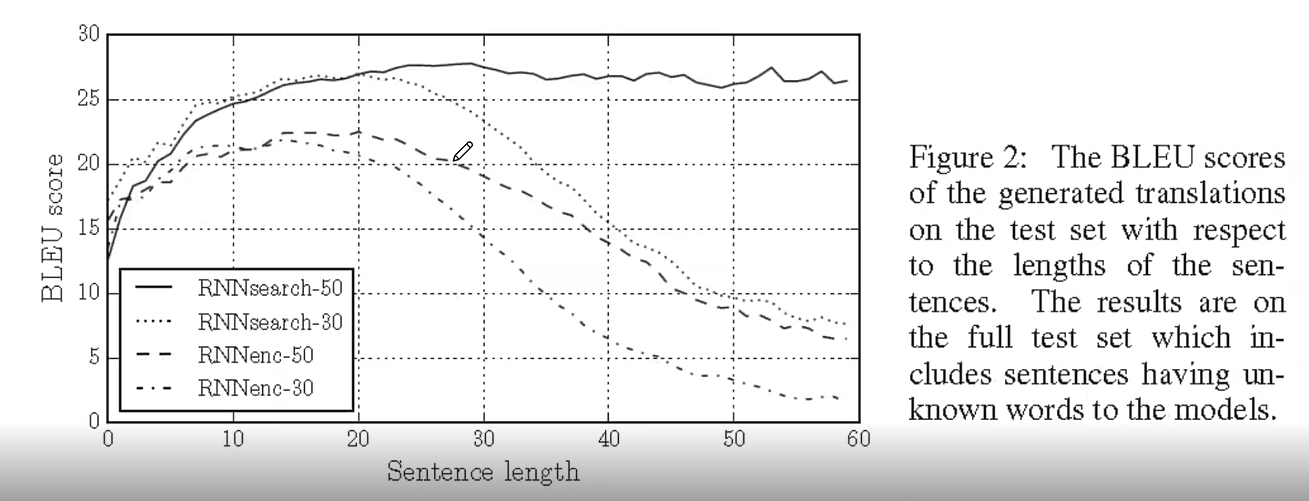

RNNsearch-x: 어텐션 기반의 인코더-디코더 모델. x 길이 이하의 문장들만으로 훈련하였음을 나타냄.  
RNNenc-x: 어텐션을 사용하지 않은 인코더-디코더 모델.

어텐션의 성능이 훨씬 강력함을 알 수 있다.